# Owl
## A Retirement Planning Laboratory

This package is a retirement modeling framework for exploring the sensitivity of retirement financial decisions. Strictly speaking, it is not a planning tool, but more an environment for exploring *what if* scenarios. It provides different realizations of a financial strategy. One can certainly have a savings plan, but due to the volatility of financial investments, it is impossible to have a certain asset earnings plan. This does not mean one cannot make decisions. These decisions need to be guided with an understanding of the sensitivity of the parameters.This is exactly where this tool fits it. Given your savings and spending desires, it can generate different future realizations of your strategy under different market assumptions, helping to better understand your financial situation.

The algorithm in Owl is using the open-source HiGHS linear programming solver.
The complete formulation and detailed description of the underlying
mathematical model can be found
[here](https://raw.githubusercontent.com/mdlacasse/Owl/main/docs/owl.pdf).

Copyright - Martin-D. Lacasse (2024)

Disclaimers: *I am not a financial planner. You make your own decisions. This program comes with no guarantee. Use at your own risk.*

### <span style="color: blue"> README FIRST </span>
<span style="color:black;background:yellow;font-weight:bold">
Don't make changes directly to this file. Keep it as a working example. Therefore, it is recommended that you build your own case by making a copy of the template files provided where you will be able to enter your own numbers and explore your own assumptions.
</span>

# Tutorial 3 - Exploring beneficiary fractions using the case of Jack and Jill
This tutorial shows how to use advanced capabilities of Owl such as Monte Carlo simulations and running simulations over a historical range. We use both these capabilities to explore the effects of beneficiary fractions on *maxSpending* and *maxBequest* optimizations. We use a similar case as the ones used in Tutorials 1 and 2 and introduce more of Owl's modeling capabilities. 

### Just some Python module bookkeeping
This command needs to be at the beginning of every Owl notebook.

In [1]:
import owl

In [2]:
owl.setVerbose(True)

Setting verbose to True


### Creating the plan (see tutorial 1 for details)
We first create a plan as we did in the *Tutorial 1*. We removed the comments for reducing the clutter.

In [3]:
plan = owl.Plan(['Jack', 'Jill'], [1962, 1965], [89, 92], 'jack+jill-tutorial3')

Preparing scenario of 34 years for 2 individuals.
          Jack: life horizon from 2024 -> 2051.
          Jill: life horizon from 2024 -> 2057.
Problem has 8 distinct time series forming 992 decision variables.
Setting 1st-year starting date to 11/26.


In [4]:
plan.setAccountBalances(
    taxable=[90, 60],
    taxDeferred=[600, 150],
    taxFree=[50 + 20, 40],
)

Taxable balances: $90,000 $60,000
Tax-deferred balances: $600,000 $150,000
Tax-free balances: $70,000 $40,000
Sum of all savings accounts: $1,010,000
Post-tax total wealth of approximately $785,000


In [5]:
plan.readContributions('jack+jill.xlsx')

Reading wages, contributions, conversions, and big-ticket items over time...
	for Jack...
	for Jill...
Successfully read time horizons from file "jack+jill.xlsx".


In [6]:
plan.setInterpolationMethod('s-curve')
plan.setAllocationRatios(
    'individual',
    generic=[[[60, 40, 0, 0], [70, 30, 0, 0]], [[60, 40, 0, 0], [70, 30, 0, 0]]],
)
# plan.showAllocations()

Asset allocation interpolation method set to s-curve.
Jack : Setting gliding allocation ratios (%) to individual
	 [60, 40, 0, 0] -> [70, 30, 0, 0]
Jill : Setting gliding allocation ratios (%) to individual
	 [60, 40, 0, 0] -> [70, 30, 0, 0]
Interpolating assets allocation ratios using s-curve method.


In [7]:
plan.setPension([0, 10], [65, 65])
plan.setSocialSecurity([28, 25], [70, 70])

Setting pension of ['$0', '$10,000'] at age(s) [65, 65]
Setting social security benefits of ['$28,000', '$25,000'] at age(s) [70, 70]


In [8]:
plan.setSpendingProfile('smile', 60)
# plan.showProfile()

Setting smile spending profile.
Securing 60% of spending amount for surviving spouse.


### Setting the heirs tax rate

In [9]:
plan.setHeirsTaxRate(33)
plan.setLongTermCapitalTaxRate(15)

Heirs tax rate on tax-deferred portion of estate set to 33%.
Long-term capital gain income tax set to 15%.


### Introducing partial spousal bequest
In some instances, the first spouse to pass can leave a fraction of her/his assets to the surviving spouse. Jack decides to give part of his assets to his children and leaves 25% of the value of his savings accounts to his surviving spouse. When not specified, default values are `[1, 1, 1]`. Changing the beneficiary fractions is done as follows. There is one value for each type of accounts: taxable, tax-deferred, and tax-free accounts.

In [10]:
plan.setBeneficiaryFractions([0.25, 0.25, 0.25])
plan.setSpousalDepositFraction(0)

Spousal beneficiary fractions set to [0.25, 0.25, 0.25]
Consider changing spousal deposit fraction for better convergence.
	Recommended: setSpousalDepositFraction(0)
Setting spousal surplus deposit fraction to 0.0.
	Jack: 1.0, Jill: 0.0


### Running a single case
We first run a single case with static *conservative* rates.
Jack and Jill desire to leave a final bequest of \\$200k (in today's \\$), leaving some security for Jill's last years. We also limit Roth conversions to a maximum of \\$100k for Jack and none for Jill, similar to the case we ran in Tutorials 1 and 2.

In [11]:
plan.setRates('conservative')
options = {'maxRothConversion': 100, 'noRothConversions': 'Jill'}
# options['solver'] = 'MOSEK'
options['bequest'] = 200
plan.solve('maxSpending', options);
plan.summary()

Using conservative fixed rates values: 6.0% 4.0% 3.3% 2.8%
Generating rate series of 34 years using conservative method.
Adjusting parameters for inflation.
Iteration: 1 objective: $82,985.64
Iteration: 2 objective: $82,761.52
Iteration: 3 objective: $82,761.52
Converged on full solution.
Self-consistent Medicare loop returned after 3 iterations.
Optimization terminated successfully. (HiGHS Status 7: Optimal)
Objective: $82,762
SUMMARY ================================================================
Plan name: jack+jill-tutorial3
        Jack's life horizon: 2024 -> 2051
        Jill's life horizon: 2024 -> 2057
Contributions file: jack+jill.xlsx
Initial balances [taxable, tax-deferred, tax-free]:
        Jack's accounts: ['$90,000', '$600,000', '$70,000']
        Jill's accounts: ['$60,000', '$150,000', '$40,000']
Return rates: conservative
Rates used (%): ['6.0', '4.0', '3.3', '2.8']
This year's starting date: 11/26
Optimized for: maxSpending
Solver options: {'maxRothConversion': 100

Looking at savings accounts, notice the drop in value taking place as Jack splits his bequest between his spouse and his children in 2051.

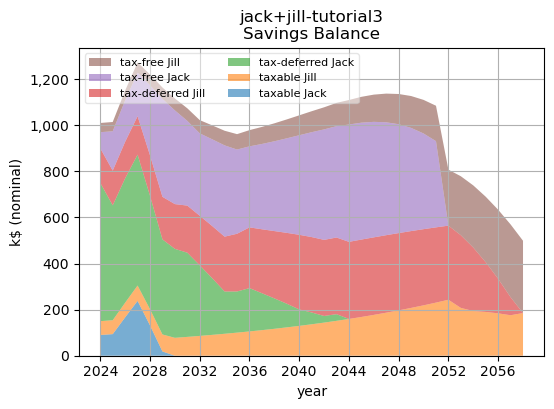

In [12]:
plan.showAccounts()

### Running Monte Carlo simulations
Before running Monte Carlo simulations, we need to configure a stochastic rate-generating method as explained in Tutorial 2. We will use a relatively conservative return projection of 8% +/- 17% for the S&P 500 and 5% +/ 8% for bonds, with 3% +/- 2% for the inflation. We use correlations derived from historical values.

In [13]:
# Mean returns
my_means = [8, 4, 4, 3]
# Volatility
my_stdev = [17, 8, 8, 2]
# Correlations matrix between rates of return of different assets
# my_corr = [[1, 0.46, 0.06, -.12], [0.46, 1, 0.68, -.27], [0.06, 0.68, 1, -.21], [-.12, -.27, -.21, 1]]
# These are only the off-diagonal elements
offdiag_corr = [.46, .06, -.12, .68, -.27, -.21]
plan.setRates('stochastic', values=my_means, stdev=my_stdev, corr=offdiag_corr)

Setting rates using stochastic method with means: 8.0% 4.0% 4.0% 3.0%
	 standard deviations: 17.0% 8.0% 8.0% 2.0%
	 and correlation matrix:
		 [[ 1.    0.46  0.06 -0.12]
		 [ 0.46  1.    0.68 -0.27]
		 [ 0.06  0.68  1.   -0.21]
		 [-0.12 -0.27 -0.21  1.  ]]
Generating rate series of 34 years using stochastic method.


In [14]:
# Display a single instance resulting from this choice.
# plan.showRatesCorrelations(shareRange=False)
# plan.showRates()

### Preparing the case to run
We now run many of those cases using the `runMC()` method. We repeat here the options used above for completeness.

When setting beneficiary fractions to less than unity, the `runMC()` and `runRange()` methods will also report a histogram of the after-tax value of the non-spousal part of the bequest made at the passing of the first spouse.

What are these cases telling us? Let's look at the specific example at hand.

In [15]:
options = {'maxRothConversion': 100, 'noRothConversions': 'Jill'}
# options['solver'] = 'MOSEK'

|--- progress ---|
	100%
CPU time used: 14m19.7s, elapsed time: 10m56.4s.
Success rate: 99.8% on 1000 samples.


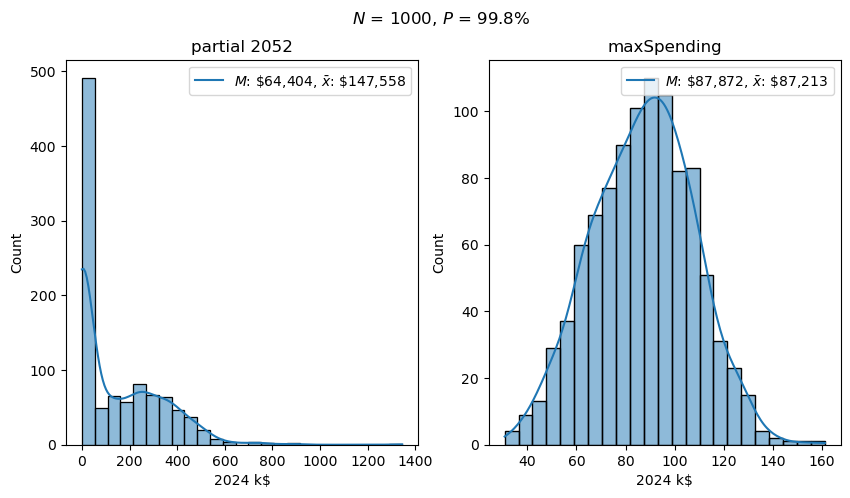

partial 2052: Median (2024 $): $64,404
partial 2052:   Mean (2024 $): $147,558
partial 2052:           Range: $0 - $1,344,542
partial 2052:  N zero solns: 435
 maxSpending: Median (2024 $): $87,872
 maxSpending:   Mean (2024 $): $87,213
 maxSpending:           Range: $30,745 - $161,183
 maxSpending:  N zero solns: 0


In [16]:
options['bequest'] = 200
plan.runMC('maxSpending', options, 1000);

*Partial* is the post-tax partial bequest left to individuals others than Jill at the passing of Jack, in that case, Jack's children. The range of values obtained in solutions is also reported as well as the number of solutions with 0 as an answer. The amount that Jack leaves to his children can vary from \\$0 to almost \\$1 M, and shows the largest variability, explaining the large difference between the median and the average. 

All cases are successful at leaving a \\$200k final bequest, but the net spending required for achieving this constraint can lead to small values in some scenarios. However, the median value $M$ for net spending is about \\$88k, very close to the \\$90k desired by Jack and Jill. Recall that we are using a more conservative return of 8%, with a volatility of 17% for the S&P 500. It is therefore natural that the number we find here is slightly lower than what the historical returns of the market have been able to provide. Some of these scenarios will yied more than the median, but some others will require a net spending of about \\$50k. All these scenarios make a probability of 100\% for leaving a \\$200k bequest at Jill's passing as requested. This is in addition to a median of about \\$20k left at Jack's passing. Mean values are indicated by $\bar{x}$. We can see that the mean value left by Jack to his children is around \\$130k while the median is much lower, due to many scenarios depleting Jack's account at his passing. What is to note is that several scenarios deplete Jack's account to reduce the partial bequest in view of maximizing the net spending. This is the action of the optimization working to fulfill its objective function.

The probability of success might be misleading here as this is the number of cases for which a solution was found, regardless of the optimal value for a net spending basis. A more useful information would consist of the fraction of all solutions larger than a value $x$. That can be derived from the histogram on the right.

Alternatively, one can look at the maximum bequest left at Jill's passing under the constraint of a net spending starting at \$80k this year (obviously in today's money). This is what the next case will do.

|--- progress ---|
	100%
CPU time used: 12m30.3s, elapsed time: 9m41.5s.
Success rate: 91.9% on 1000 samples.


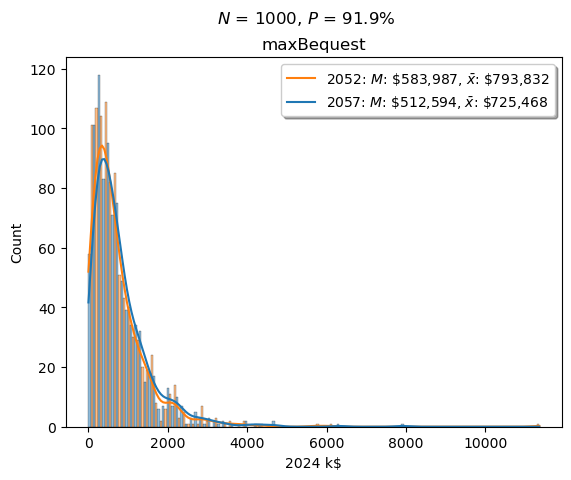

partial 2052: Median (2024 $): $583,987
partial 2052:   Mean (2024 $): $793,832
partial 2052:           Range: $0 - $7,917,698
partial 2052:  N zero solns: 8
  final 2057: Median (2024 $): $512,594
  final 2057:   Mean (2024 $): $725,468
  final 2057:           Range: $1,668 - $11,362,647
  final 2057:  N zero solns: 0


In [17]:
options['netSpending'] = 80
plan.runMC('maxBequest', options, 1000);

In this case, a relatively good fraction of scenarios are successful in providing the desired \\$80k net spending amount modulated over the duration of the plan. The median bequest left at the end of the plan is close to \\$500k, while Jack's partial bequest is only a little less. A success rate of 85% is relatively good, especially considering the fact that Jack and Jill are always able to re-adjust their net spending plan as other forward-looking estimates are performed in the future, and that the partial bequest left to Jack's children is a percentage, not an absolute quantity. This suggests that by reducing their spending by \\$10k, Jack and Jill can provide a total bequest of about \\$1 M in two separate bequests, a first in 2051, and then another one in 2057.

### Running cases over a historical range or years
As with full spousal asset transfer, we can also run the same cases using historical data over a range of years and compile the outcomes in a histogram. For this purpose, there is no need to pre-select specific rates using the `setRates()` method as the choice of *historical* rates is implicit. Only the year range is required.

Let's look at a specific example. For optimizing the net spending amount, we specify *maxSpending* in the following call to optimize the plan over the 63 years following 1928:

|--- progress ---|
	100%
Success rate: 100.0% on 63 samples.
Optimized solution led to a zero partial bequest in year 2052.


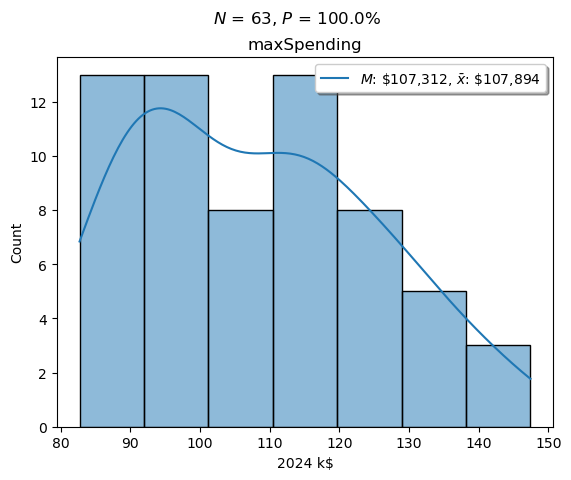

 maxSpending: Median (2024 $): $107,312
 maxSpending:   Mean (2024 $): $107,894
 maxSpending:           Range: $82,726 - $147,426
 maxSpending:  N zero solns: 0
CPU times: total: 1min 53s
Wall time: 1min 22s


In [18]:
%%time
plan.runHistoricalRange('maxSpending', options, 1928, 1990);

When considering more historical data than a single year, we find that most solutions lead to empty accounts at Jack's passing. 

Let's now consider the case for *maxBequest* under a desired net spending.

|--- progress ---|
	100%
Success rate: 100.0% on 63 samples.


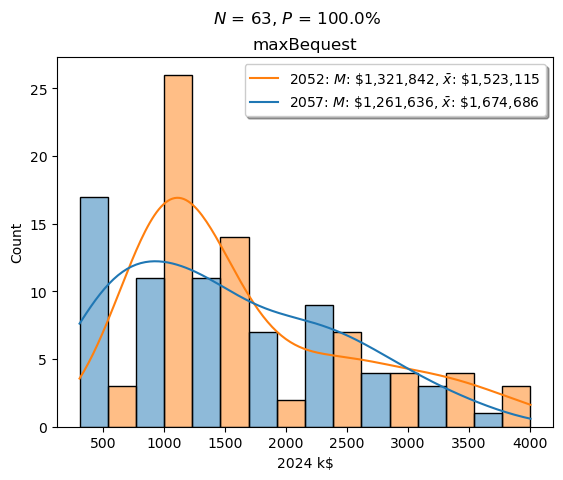

partial 2052: Median (2024 $): $1,321,842
partial 2052:   Mean (2024 $): $1,523,115
partial 2052:           Range: $308,440 - $3,701,118
partial 2052:  N zero solns: 0
  final 2057: Median (2024 $): $1,261,636
  final 2057:   Mean (2024 $): $1,674,686
  final 2057:           Range: $658,440 - $4,007,363
  final 2057:  N zero solns: 0
CPU times: total: 2min 36s
Wall time: 2min 12s


In [19]:
%%time
plan.runHistoricalRange('maxBequest', options, 1928, 1990);

The resulting success rate when considering all historical data is 100%. This is also not surprising as the original estimates for the net spending and the bequest were derived from running a case in 1969, the second next worst year of historical sequences of returns. 